## Background

This is me following along and recreating Andrej Karpathy's excellent youtube lectures on implementing neural networks from scratch :)

## What you will find in this notebook
A recreation of https://www.youtube.com/watch?v=VMj-3S1tku0 with my own added comments (and sometimes more intermediary steps.):
- Implementation of the Value class, a "handcrafted" implentation of tensors.
- Implementation of basic arithmetic functions on the Value objects.
- Incremental derivation of the Value objects.
- Step by step implementation of backpropagation through 1. the atomic gradient pieces 2. the chain rule 3. step-by-step "show your work" explanation.
- Comparison with PyTorch library.
- Implementation of Neurons, Layers and Multi-Layer Perceptron all atop our custom Value class!

## Micrograd - motivation
- Micrograd will help us implement _backpropation_. 
- **Backpropagation** is one of the key building blocks of neural networks.
    - The way I like to think about it is as a math formula that sends a lot of small modifications through your network weights to say:
        - _"hey, this is what I just learned from my mistakes on this training data"._
    - If you do it a lot, on a lot of data, your network will (like a diligent) learns from its mistakes and hopefully do less mistakes.
        - That is minimizing the loss function.
    - This is what allows neural network to get really good at the specific tasks they're trained on.
- Repeated backpropagation is therefore one of the mechanisms that allows you to learn from large scale of data.

# Very basics of number representations as tensors

In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(72)

In [2]:
def f(x):
    return 3*x**2 -4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)

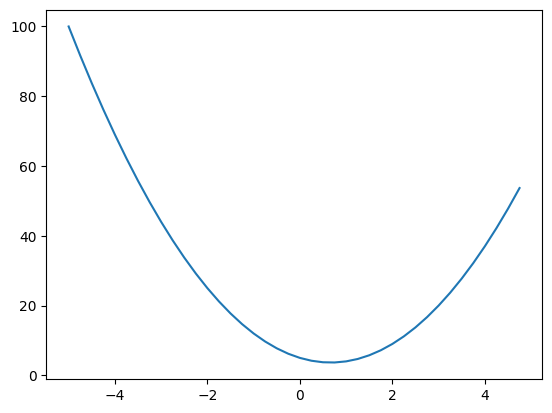

In [6]:
plt.plot(xs, ys)

Let's dive deeper into the gradient and values it would take around x=3

In [7]:
h = 0.001
x = 3.0
print(f"f(x) = {f(x)}")
print(f"f(x+h) = {f(x+h)}")
print(f"f(x+h) - f(x) = {f(x+h) - f(x)}")
print(f"(f(x+h) - f(x))/h = {(f(x+h) - f(x))/h}")

f(x) = 20.0
f(x+h) = 20.014003000000002
f(x+h) - f(x) = 0.01400300000000243
(f(x+h) - f(x))/h = 14.00300000000243


What about x=-3?

In [8]:
h = 0.000000001
x = -3.0
print(f"f(x) = {f(x)}")
print(f"f(x+h) = {f(x+h)}")
print(f"f(x+h) - f(x) = {f(x+h) - f(x)}  # this is the slope")
print(f"(f(x+h) - f(x))/h = {(f(x+h) - f(x))/h} # rise over run")

f(x) = 44.0
f(x+h) = 43.999999978
f(x+h) - f(x) = -2.2000001820288162e-08  # this is the slope
(f(x+h) - f(x))/h = -22.000001820288162 # rise over run


In [9]:
h = 0.00000001
x = 2/3
print(f"f(x) = {f(x)}")
print(f"f(x+h) = {f(x+h)}")
print(f"f(x+h) - f(x) = {f(x+h) - f(x)}")
print(f"(f(x+h) - f(x))/h = {(f(x+h) - f(x))/h}")

f(x) = 3.666666666666667
f(x+h) = 3.666666666666667
f(x+h) - f(x) = 0.0
(f(x+h) - f(x))/h = 0.0


In [10]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


Let's evaluate the derivative of `d` with respect to `a`, `b` or `c`

In [11]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print(f"d1 = {d1}")
print(f"d2 = {d2}")
print(f"slope = {(d2 - d1)/h}")

d1 = 4.0
d2 = 3.999699999999999
slope = -3.000000000010772


In [12]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print(f"d1 = {d1}")
print(f"d2 = {d2}")
print(f"slope = {(d2 - d1)/h}")

d1 = 4.0
d2 = 4.0002
slope = 2.0000000000042206


In [13]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print(f"d1 = {d1}")
print(f"d2 = {d2}")
print(f"slope = {(d2 - d1)/h}")

d1 = 4.0
d2 = 4.0001
slope = 0.9999999999976694


In [14]:
d2

4.0001

# Defining a Value class for neurons

In [15]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        return out

In [16]:
a = Value(2.0)
b = Value(-3.0)
a + b

Value(data=-1.0)

In [17]:
c = Value(10.0)
a*b + c

Value(data=4.0)

In [18]:
(a.__mul__(b))

Value(data=-6.0)

In [19]:
(a.__mul__(b)).__add__(c)

Value(data=4.0)

In [20]:
d = a*b + c

In [21]:
d

Value(data=4.0)

In [22]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [23]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f}" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [24]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
e = a*b; e.label = 'e'
c = Value(10.0, label='c')
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

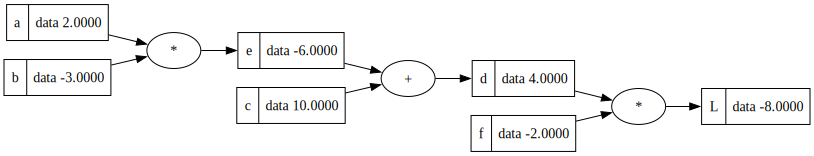

In [25]:
draw_dot(L)

This is the **forward pass**, with -8 as its output.

How do we _reverse_ this to get to _backpropagation_?

# Including the gradients

In [26]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        return out

In [27]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [28]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
e = a*b; e.label = 'e'
c = Value(10.0, label='c')
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

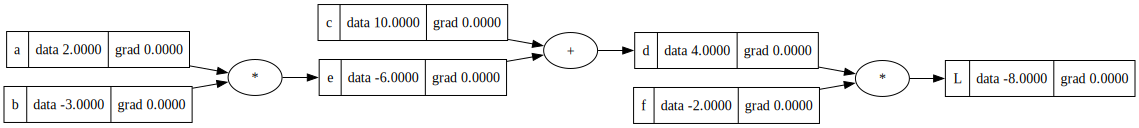

In [29]:
draw_dot(L)

In [30]:
L.grad = 1.0

Let's manually compute the derivatives of the end node with respect to the input nodes, and fit those values to the gradient!

(Basically, we are answering: by how much is L dependent on the change in d or in f. The gradient is the local rate of change.)

```
L = d * f
dL/dd = f = -2.0 
    -> d.grad = -2.0
dL/df = d = 4.0 
    -> f.grad = 4.0```

In [31]:
f.grad = d.data
d.grad = f.data

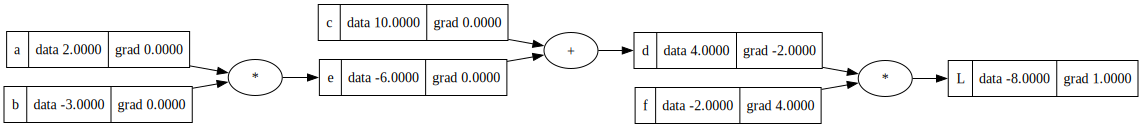

In [32]:
draw_dot(L)

In [33]:
def lol():
    h = 0.0001
    # function for staging without modifying the global scope
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print(f"(L1 - L2)/h = {(L1 - L2)/h}")

In [34]:
lol()

(L1 - L2)/h = 1.9999999999953388


### The critical node to understand! Chain rule.

How do you get to dL / dc?

```
dd / dc = ?

d = c + e
dd / dc = 1.0
dd / de = 1.0

```
The local derivatives are equal to 1.
and we have the other local derivatives (computed earlier) - so let's put it together!

$$\frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc} $$

```
dL/dc = dL/dd * dd/dc = -2.0 * dd/dc = -2.0 * 1.0
```

In [35]:
c.grad = -2.0
e.grad = -2.0

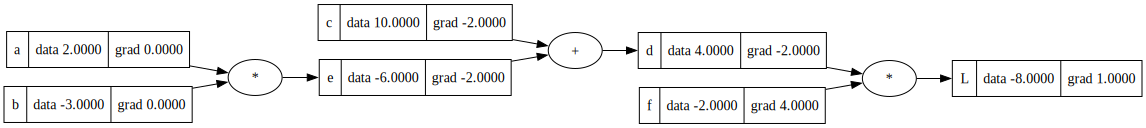

In [36]:
draw_dot(L)

Notice how we are **back-propagating** the gradients all the way _back_ to the start of the graph!

```
dL / de = -2.0

dL / da = dL/de * de/da

e = a * b
de/da = b = 3.0
dL / da = -2.0 * de/da
de/db = a = -2.0
```

In [37]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

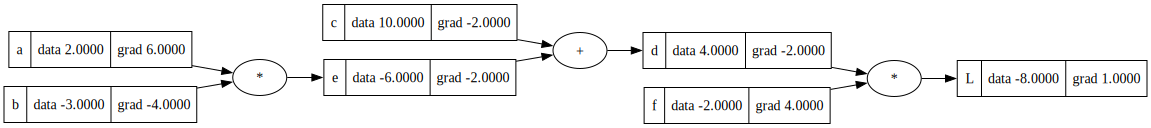

In [38]:
draw_dot(L)

We have **manually** computed the backpropagation algorithm through this neural network!
Now what if we updated our node weights based on the direction of the gradient?

In [39]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-7.286496


We have moved in the direction of optimizing L to be bigger!

In [40]:
def lol():
    h = 0.001
    # function for staging without modifying the global scope
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data +=h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    # d.data += h
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print(f"(L1 - L2)/h = {(L1 - L2)/h}")

lol()

(L1 - L2)/h = 3.9999999999995595


# End-to-end example: backpropagating through a small neuron

Now let's throw in some activation functions...

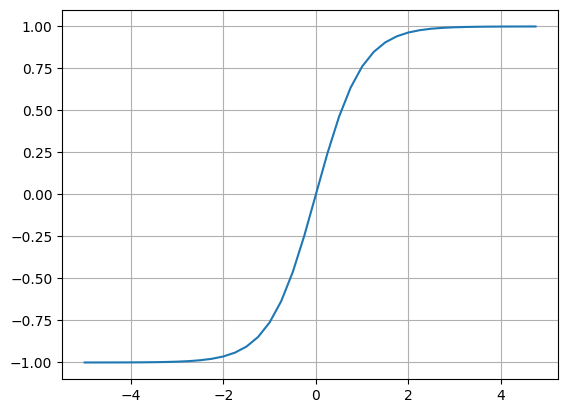

In [41]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25))); plt.grid()

Let's add it to the value functions.

In [42]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        return out
    
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

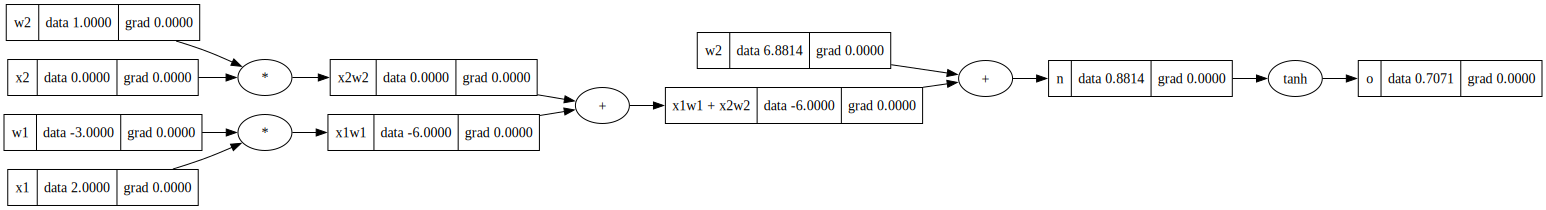

In [43]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='w2')
# x1w1 + w2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # neuron
# activation function
o = n.tanh(); o.label = 'o' #output!
draw_dot(o)

By playing around with different values of parameters, we can see how the tanh function squashes it!

In [44]:
o.grad = 1.0
o.data

0.7071067811865476

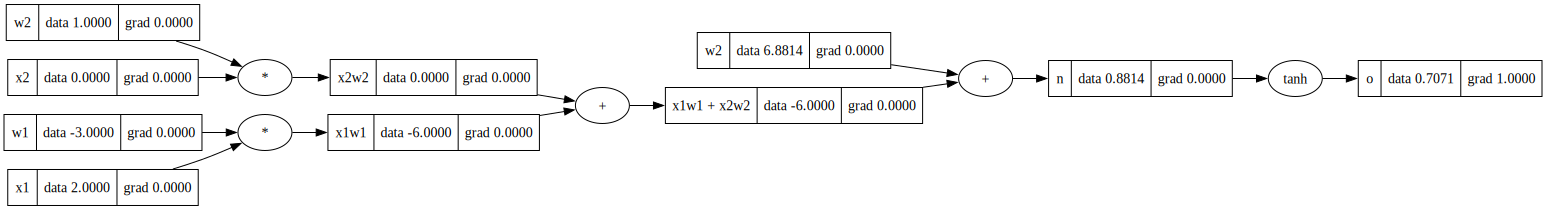

In [45]:
draw_dot(o)

Finding the local derivative of tanh.

```
o = tan(h)
dtanh(x)/dx = 1 - tanh(x)**2
do/dn = 1- o**2
```

In [46]:
1 - o.data**2

0.4999999999999999

In [47]:
n.grad = 0.5

In [48]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [49]:
x1w1.grad = 0.5
x2w2.grad = 0.5

The '+' is the best operation to backpropagate... you just transfer the grad!

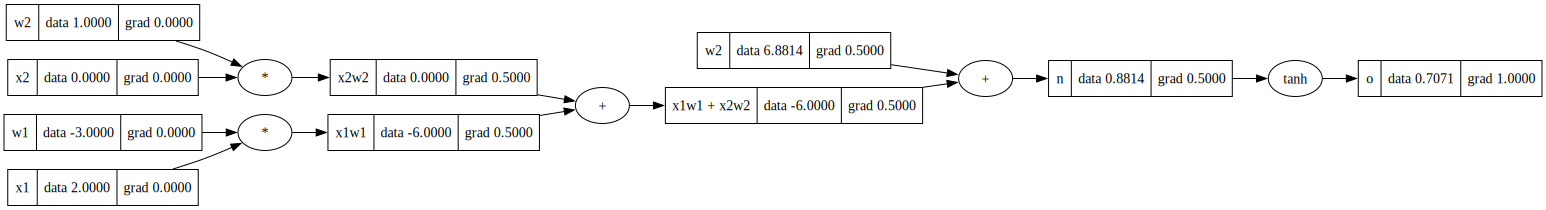

In [50]:
draw_dot(o)

Let's backpropagate with the multiples. 

In [51]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [52]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

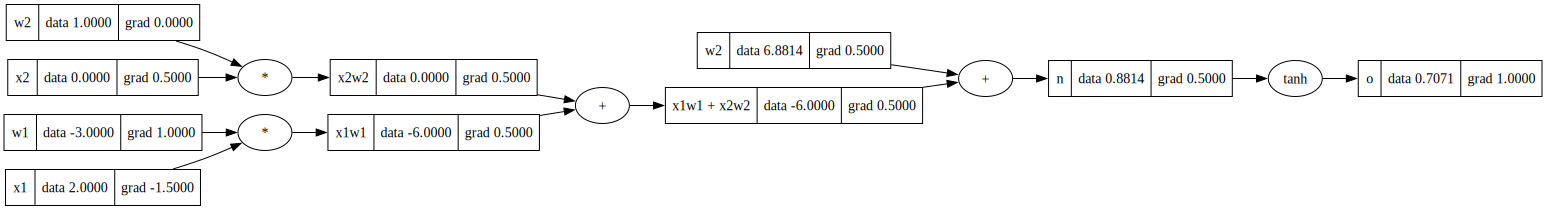

In [53]:
draw_dot(o)

We have completed the backpropagation!

We now know that if we wanted our output `o` to increase, we could increase the value of w1, but that increasing the value of w2 would be useless currently.

# Implementing backpropagation in our Value objects

We have observed that the backpropagation is determined by the operation types in the cells that flow through the network.

In [54]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # _backward is a function!
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        # we are defining a backward prop method for each operation type!
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out

The `_backward` methods modifies the gradients of each nodes when it is called, and is being called in the backward order.

Let's reinitialize our network with all grads at 0.

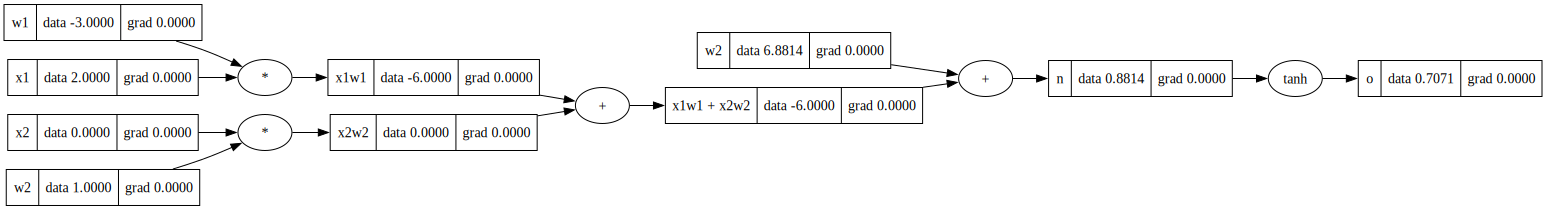

In [55]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='w2')
# x1w1 + w2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # neuron
# activation function
o = n.tanh(); o.label = 'o' #output!
draw_dot(o)

In [56]:
o.grad = 1.0

In [57]:
o._backward()

In [58]:
n._backward()
n.grad

0.4999999999999999

In [59]:
b._backward()
b.grad

0.4999999999999999

In [60]:
x1w1x2w2._backward()

In [61]:
x2w2._backward()
x1w1._backward()

Now let's think about the execution order for a minute. We always want a node's backprop to be called before the parent's backprop. In practice we leverage the graph structure to build a topological order in which to traverse the nodes.

In [62]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

We can bake that in our method logic's by implementing a method that:
- generates a node's topology
- updates the gradient by calling the backwards methods all across the order

In [63]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # _backward is a function!
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        # we are defining a backward prop method for each operation type!
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [64]:
# Reinitialize graph

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='w2')
# x1w1 + w2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # neuron
# activation function
o = n.tanh(); o.label = 'o' #output!
# draw_dot(o)

In [65]:
o.backward()

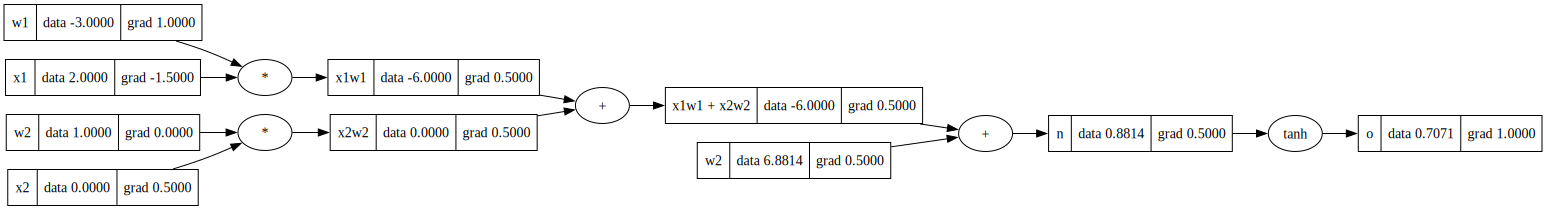

In [66]:
draw_dot(o)

Now we need to think of a **very problematic edge case** with the current implementation!
If a variable is used in multiple cells here...
It would be overwritten!!

Because there is additivity in the chain rule, we can correct that by replacing most `=` to `+=` in the Value objects _backwards method.

In [67]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # _backward is a function!
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        # we are defining a backward prop method for each operation type!
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

# Implement further functions in the Value object.

First we need to implement a behavior to automatically turn constraints to values.

```
a + 1
```

would return an error as it is.

How do we correct our class to fix that error?

In [68]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [69]:
a = Value(2.0)
a + 1

Value(data=3.0)

In [70]:
a = Value(2.0)
2 * a, a * 2

(Value(data=4.0), Value(data=4.0))

In [71]:
a = Value(2.0)
b = Value(4.0)
# a / b = a * (1/b) where (1/b) = b**(-1)
# so we built the exponentiation operator!
a / b

Value(data=0.5)

In [72]:
a - b

Value(data=-2.0)

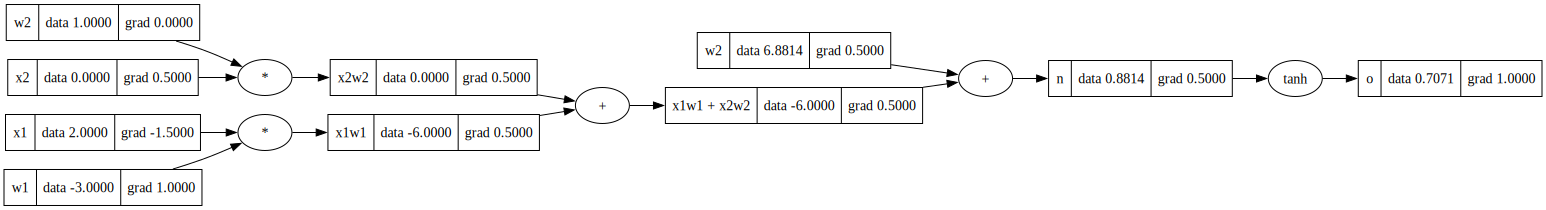

In [73]:
# Reinitialize graph

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='w2')
# x1w1 + w2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # neuron
# activation function
o = n.tanh(); o.label = 'o' #output!
o.backward()
draw_dot(o)


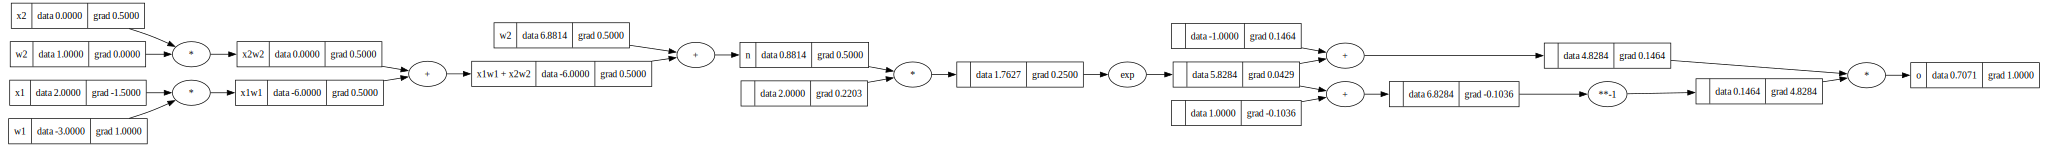

In [74]:
# Reinitialize graph

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='w2')
# x1w1 + w2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n' # neuron
# -------------------------------
e = (2*n).exp()
o = (e - 1)/(e + 1) # tanh rewritten with the functions we have just defined
# -------------------------------
o.label = 'o' #output!
o.backward()
draw_dot(o)


The graph is now much longer as we have broken down the activation in multiple graphs! But we get the same values which confirms that our backward pass is correct.

# Comparing with PyTorch tensors implementation!

In [75]:
import torch

In [76]:
x1 = torch.Tensor([2.0]).double() # forcing double precision instead of float (default)
x1.requires_grad = True # telling pytorch to track gradients for this variable (default is False for scalars)
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # .item() to get the value of a scalar tensor
o.backward()

print('_________')
print(f"x2.grad = {x2.grad.item()}")
print(f"w2.grad = {w2.grad.item()}")
print(f"x1.grad = {x1.grad.item()}")
print(f"w1.grad = {w1.grad.item()}")

0.7071066904050358
_________
x2.grad = 0.5000001283844369
w2.grad = 0.0
x1.grad = -1.5000003851533106
w1.grad = 1.0000002567688737


Let's design a neural network module in the PyTorch way.

In [77]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum( (wi*xi for (wi, xi) in zip(self.w, x)), self.b)
        # using the property of sum taking a second argument as the starting value!
        out = act.tanh()
        return out
    
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.37743585781109434)

In [78]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # return a nice value if not multi-dimensional

    
x = [2.0, 3.0]
n = Layer(2,3)
n(x)

[Value(data=-0.7023224160733221),
 Value(data=-0.9612585681323449),
 Value(data=0.45338306519067056)]

In [79]:
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts # sizes of the layers - nin is the size of the input and nouts is a list of sizes of the hidden layers
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.11791870085145649)

Now, let's recall we built this whole architecture on top of our tensors defined from scratch!

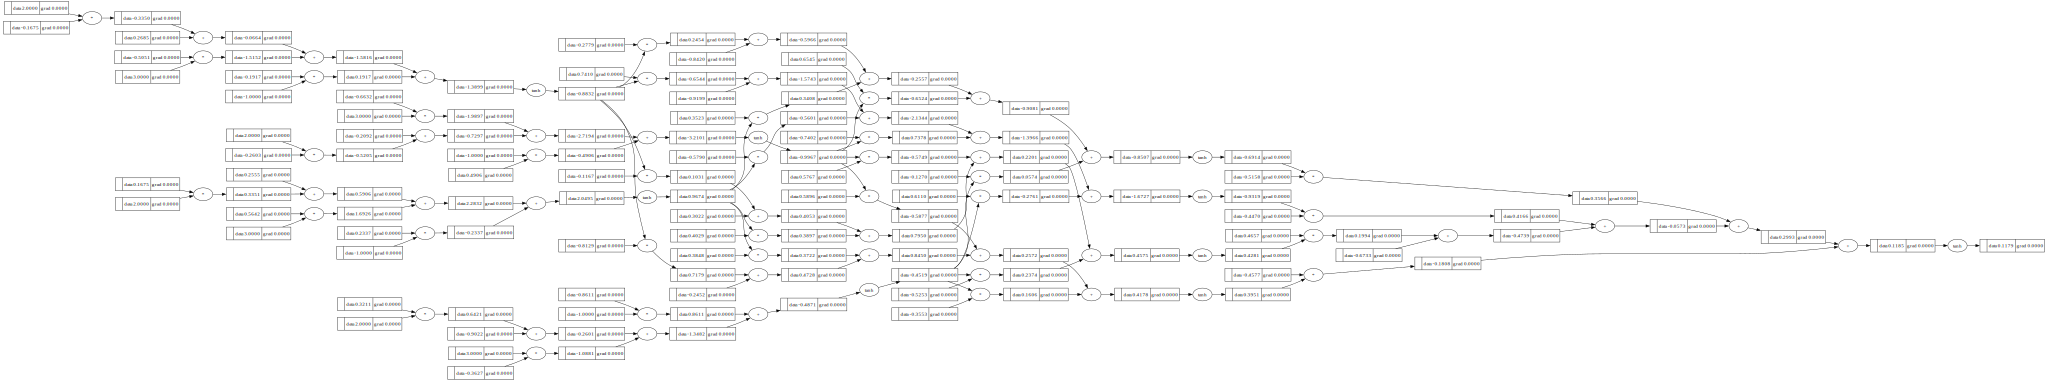

In [80]:
draw_dot(n(x))

Yeah, we'd never want to differentiate to that by hand.

# Now can we try this with some data?!

In [81]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [82]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.11791870085145649),
 Value(data=0.2935829940280219),
 Value(data=0.15745898619237056),
 Value(data=0.23936931687030175)]

Yeah, those are not very good predictions!
This is where defining a **loss** that define how good we are currently at the task at hand.

In [83]:
[(y_ground_truth, y_output ) for y_ground_truth, y_output in zip(ys, ypred)]

[(1.0, Value(data=0.11791870085145649)),
 (-1.0, Value(data=0.2935829940280219)),
 (-1.0, Value(data=0.15745898619237056)),
 (1.0, Value(data=0.23936931687030175))]

In [84]:
[(y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred)]

[Value(data=0.7780674183075823),
 Value(data=1.6733569624385014),
 Value(data=1.3397113047174702),
 Value(data=0.5785590361183515)]

In [85]:
loss = sum((y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred))

In [86]:
loss.backward()

In [87]:
n.layers[0].neurons[0].w[0].grad

1.2956209093387328

Let's remember that we had built the graph of the loss before!

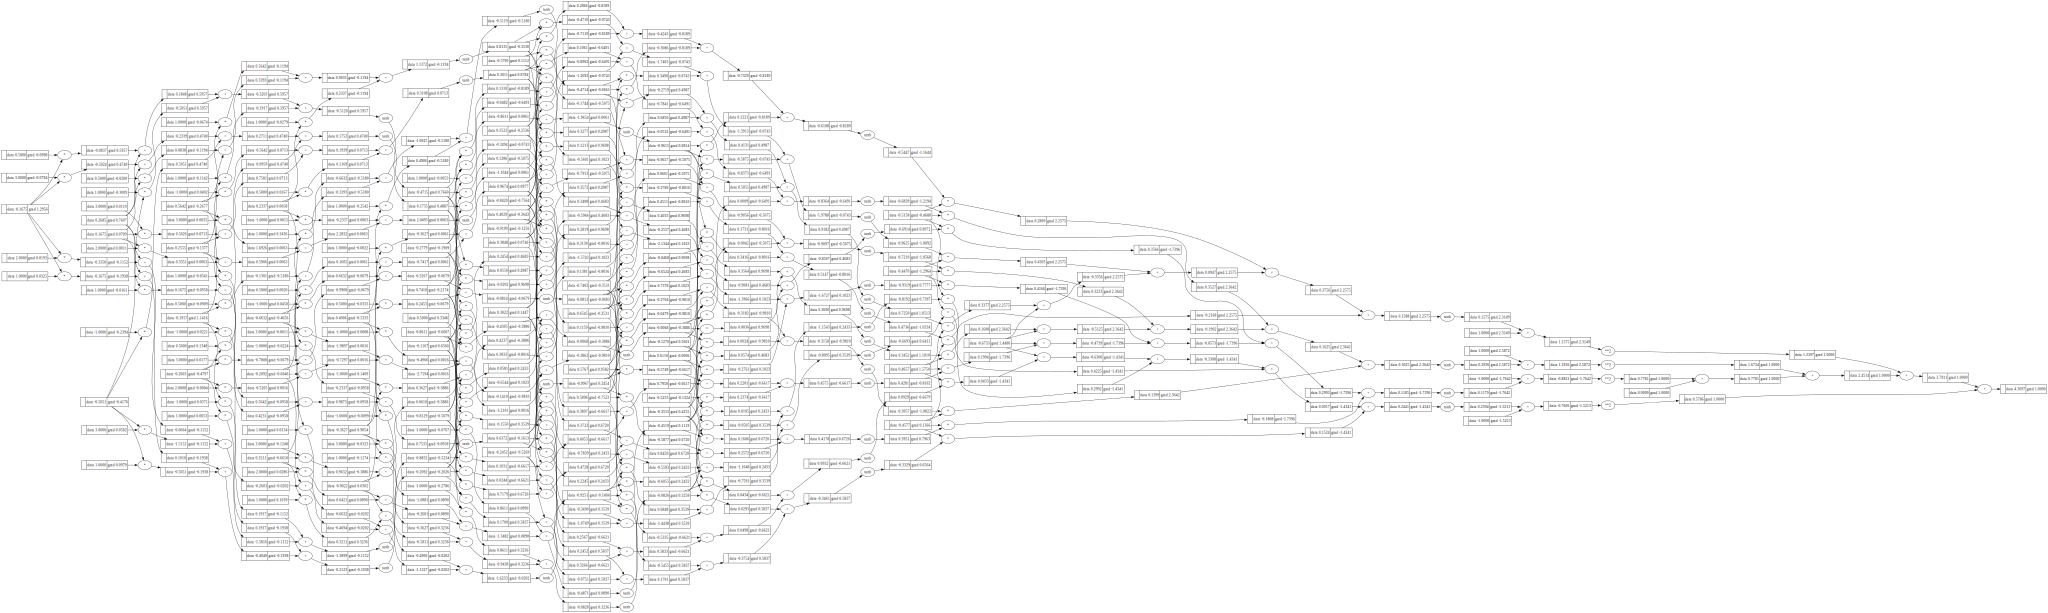

In [88]:
draw_dot(loss)

Massive, right.

How can we rewrite our implementations in order to easily retrieve the parameters of the network?

In [89]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum( (wi*xi for (wi, xi) in zip(self.w, x)), self.b)
        # using the property of sum taking a second argument as the starting value!
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # return a nice value if not multi-dimensional

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts # sizes of the layers - nin is the size of the input and nouts is a list of sizes of the hidden layers
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]


In [90]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.3020763457866082)

In [91]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.3020763457866082),
 Value(data=0.294939390295107),
 Value(data=-0.1715555730979028),
 Value(data=-0.11808383639687134)]

In [92]:
loss = sum((y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred))

In [93]:
loss.data

5.30870246847196

In [94]:
loss.backward()

In [95]:
n.layers[0].neurons[0].w[0].grad

2.5712082989052427

In [96]:
n.layers[0].neurons[0].w[0].data

-0.9055820530328191

We want to change the value of the weights according to their gradients - making a tiny move in the direction of the gradient.

In [97]:
# thanks to the parameters() method, we can now do this on all weights and biases
for p in n.parameters():
    p.data -= 0.01 * p.grad # -= because we want to minimize the loss
                            # so we go in the opposite direction of the gradient!

    


In [98]:
n.layers[0].neurons[0].w[0].data

-0.9312941360218716

In [99]:
ypred = [n(x) for x in xs]
loss = sum((y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred))
loss.data

4.672071307413099

**Our loss has decreased from 5.3 to 4.6!!**

In [100]:
loss.backward() # forward pass + backward pass
for p in n.parameters(): # update weights
    p.data -= 0.01 * p.grad

ypred = [n(x) for x in xs]
loss = sum((y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred))
loss.data

3.714049338552045

We are iteratively making our network learn better weights for the data!
What happens if we change the learning rate?

In [101]:
loss.backward() # forward pass + backward pass
for p in n.parameters(): # update weights
    p.data -= 0.1 * p.grad

ypred = [n(x) for x in xs]
loss = sum((y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred))
loss.data

5.634980918088651

**Oops...** we went way to fast and overstepped and the loss grew again!

In [102]:
loss.backward() # forward pass + backward pass
for p in n.parameters(): # update weights
    p.data -= 0.01 * p.grad

ypred = [n(x) for x in xs]
loss = sum((y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred))
loss.data

5.111870472088937

In [103]:
loss.backward() # forward pass + backward pass
for p in n.parameters(): # update weights
    p.data -= 0.01 * p.grad

ypred = [n(x) for x in xs]
loss = sum((y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred))
loss.data

3.9315411732582146

In [104]:
loss.backward() # forward pass + backward pass
for p in n.parameters(): # update weights
    p.data -= 0.01 * p.grad

ypred = [n(x) for x in xs]
loss = sum((y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred))
loss.data

2.993620685390229

In [105]:
loss.backward() # forward pass + backward pass
for p in n.parameters(): # update weights
    p.data -= 0.01 * p.grad

ypred = [n(x) for x in xs]
loss = sum((y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred))
loss.data

2.2104484574050938

If only there was a better way to iterate to convergence...

**Here at this stage, we need to point out a failure in our implentation**: the gradients need to be reset to 0 before the backwards pass. This is common across our implentation and the PyTorch implementation!

In [106]:
for i in range(20):
    for p in n.parameters():
        p.grad = 0.0

    loss.backward() # forward pass + backward pass
    for p in n.parameters(): # update weights
        p.data -= 0.01 * p.grad

    ypred = [n(x) for x in xs]
    loss = sum((y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred))

    print(f"{i} : {loss.data}")

0 : 2.023390298847139
1 : 1.8317360049190752
2 : 1.6383106158233856
3 : 1.448783650808227
4 : 1.27142674447974
5 : 1.1132928135563667
6 : 0.9770772348294104
7 : 0.8617815711932555
8 : 0.7648413781233288
9 : 0.6834266291742368
10 : 0.6149165726542251
11 : 0.5570362193201767
12 : 0.5078766439392381
13 : 0.4658689718419079
14 : 0.42973955971302835
15 : 0.39846084688954303
16 : 0.37120537419296945
17 : 0.3473060881071088
18 : 0.3262235852764584
19 : 0.3075197784124151


In [107]:
for i in range(100):
    for p in n.parameters():
        p.grad = 0.0

    loss.backward() # forward pass + backward pass
    for p in n.parameters(): # update weights
        p.data -= 0.01 * p.grad

    ypred = [n(x) for x in xs]
    loss = sum((y_output - y_ground_truth)**2 for y_ground_truth, y_output in zip(ys, ypred))

    print(f"{i} : {loss.data}")

0 : 0.2908370318196821
1 : 0.2758817533806128
2 : 0.2624115279807804
3 : 0.25022502649337086
4 : 0.2391540747200535
5 : 0.22905739857485552
6 : 0.2198156701819451
7 : 0.21132756552396711
8 : 0.20350661111281965
9 : 0.19627864854212435
10 : 0.18957978506707218
11 : 0.1833547283273269
12 : 0.17755542619490228
13 : 0.1721399502051672
14 : 0.16707157442299778
15 : 0.16231801189720155
16 : 0.15785077881039045
17 : 0.15364466259968307
18 : 0.14967727512840798
19 : 0.1459286757489609
20 : 0.1423810520529477
21 : 0.1390184484394593
22 : 0.13582653448476795
23 : 0.13279240657320776
24 : 0.12990441743104883
25 : 0.12715202915559826
26 : 0.1245256860992307
27 : 0.12201670459031536
28 : 0.11961717697960506
29 : 0.11731988791467271
30 : 0.11511824108465014
31 : 0.11300619495721259
32 : 0.11097820626087587
33 : 0.10902918015734588
34 : 0.10715442620812264
35 : 0.10534961937269555
36 : 0.10361076538713869
37 : 0.10193416996556443
38 : 0.1003164113457844
39 : 0.09875431576719038
40 : 0.097244935525349

In [108]:
[y.data for y in ypred]

[0.893985207961689,
 -0.8891525009907524,
 -0.8841998933393106,
 0.8750260677985422]

In [109]:
ys

[1.0, -1.0, -1.0, 1.0]

The predictions are pretty good - our network successfully overfit to a small batch.